In [2]:
!pip install jupyterthemes
!jt -t chesterish

In [1]:
from requests import get
from json import loads
from urllib.parse import unquote
import pandas as pd

## Topic Crawler

### Query DuckDuckGo REST API for topics
### Follow related topics
### Filter and normalize topics

In [2]:
topic_url_format = 'https://api.duckduckgo.com/?q={search_term}&format=json&pretty=1'

In [3]:
topic_seed = ['user experience design']

In [4]:
from time import sleep
topic_df = pd.DataFrame()
related_topic_df = pd.DataFrame()
for depth in range(2):
    if not depth:
        topics = topic_seed
    related_topics = []
    topic_rows = []
    related_topic_rows = []
    for topic in topics:
        try:
            print(topic)
            sleep(0.1)
            response = get(topic_url_format.format(search_term=topic))
            content = loads(response.content)
            data = {}
            data['topic'] = content['Heading'].lower()
            data['abstract'] = content['Abstract']
            data['document_type'] = content['Type']
            data['topic_wiki_url'] = content['AbstractURL']
            topic_rows.append(data)   

            for result in content['RelatedTopics']:
                row = {}
                row['depth'] = depth
                row['related_topic'] = unquote(result['FirstURL'].replace(
                    'https://duckduckgo.com/', '').replace('c/', '').replace('_', ' ')).lower()
                row['related_topic_text'] = result['Text']
                row.update(data)
                related_topic_rows.append(row)
                related_topics.append(row['related_topic'])
        except KeyError as e:
            print('Error on topic: ' + topic + ' : ' + str(e))
    topics = related_topics
    topic_df = topic_df.append(pd.DataFrame(topic_rows))
    related_topic_df = related_topic_df.append(pd.DataFrame(related_topic_rows))

user experience design
action research
activity-centered design
customer experience
design thinking
paper prototyping
participatory design
web design
software development process
user interfaces
human–computer interaction
design
Error on topic: design : 'FirstURL'


In [33]:
related_topic_df.head()

,abstract,depth,document_type,related_topic,related_topic_text,topic,topic_wiki_url
0,User experience design is the process of manip...,0,A,action research,Action research - Action research is a philoso...,user experience design,https://en.wikipedia.org/wiki/User_experience_...
1,User experience design is the process of manip...,0,A,activity-centered design,Activity-centered design - Activity-centered d...,user experience design,https://en.wikipedia.org/wiki/User_experience_...
2,User experience design is the process of manip...,0,A,customer experience,"Customer experience - In commerce, customer ex...",user experience design,https://en.wikipedia.org/wiki/User_experience_...
3,User experience design is the process of manip...,0,A,design thinking,Design thinking - Design thinking refers to th...,user experience design,https://en.wikipedia.org/wiki/User_experience_...
4,User experience design is the process of manip...,0,A,paper prototyping,Paper prototyping - In human–computer interact...,user experience design,https://en.wikipedia.org/wiki/User_experience_...


In [6]:
related_topic_df.to_csv('topic_database.csv')

In [7]:
### Write topics to graph JSON for d3

## Search Engine Crawler

In [9]:
from os import environ
# environ['BING_API_KEY'] = 'remove comment, replace with your API key, run the cell, remove key, add comment'
bing_api_key = environ['BING_API_KEY']

In [172]:
search_seed = set(related_topic_df['related_topic'].unique())
search_seed.update(set(related_topic_df['topic'].unique()))
len(search_seed)

71

In [173]:
def search(search_term):
    search_url = "https://api.cognitive.microsoft.com/bing/v7.0/search"
    headers = {"Ocp-Apim-Subscription-Key": bing_api_key}
    params = {
        "q": search_term, 
        "textDecorations": True, 
        "textFormat": "Raw", 
        "responseFilter": "webpages", 
        "count": 50}
    sleep(0.4)
    response = get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    return search_results

In [174]:
def filter_search_results(raw_search_results):
    keys = ['name', 'url', 'snippet', 'dateLastCrawled']
    for result in raw_search_results:
        topic = result['queryContext']['originalQuery']
        for page in result['webPages']['value']:
            row = {key: page[key] for key in keys}
            row['topic'] = topic
            yield row

In [175]:
#raw_search_results = [search(search_term=search_term) for search_term in list(search_seed)]

In [176]:
#search_results = pd.DataFrame(filter_search_results(raw_search_results))
#search_results = pd.DataFrame.from_csv('search_results_database.csv')

In [177]:
search_results.head()

,dateLastCrawled,name,snippet,topic,url
0,2020-04-13T13:29:00.0000000Z,Lateral thinking - Wikipedia,Lateral thinking is a manner of solving prob...,lateral thinking,https://en.wikipedia.org/wiki/Lateral_thinking
1,2020-04-08T15:21:00.0000000Z,Lateral Thinking - How can Lateral Thinking...,Lateral Thinking Lateral Thinking is the S...,lateral thinking,https://www.edwddebono.com/lateral-thinking
2,2020-04-13T23:46:00.0000000Z,Lateral Thinking Puzzles - Preconceptions,Lateral thinking puzzles that challenge your...,lateral thinking,http://www.folj.com/lateral/
3,2020-04-13T06:39:00.0000000Z,How to Practice Lateral Thinking - ThoughtCo,Lateral thinking involves looking at a situa...,lateral thinking,https://www.thoughtco.com/lateral-thinking-185...
4,2020-04-13T20:11:00.0000000Z,www.puzzles9.com,www.puzzles9.com,lateral thinking,http://www.puzzles9.com/18-challenging-lateral...


In [184]:
search_results.to_csv('search_results_database.csv')

In [182]:
search_results['topic'].unique()

array(['lateral thinking', 'services marketing',
       'participatory action research', 'prototype', 'user interface',
       'user experience design', 'cardboard modeling', 'software design',
       'virtual reality', 'graphic design', 'participatory design',
       'brain-computer interface', 'information design',
       'human–computer interaction', 'communication design',
       'human-computer interaction', 'user interfaces',
       'computer-supported cooperative work', 'problem solving',
       'social science methodology', 'mindfulness and technology',
       'software engineering', 'user experience', 'methodology',
       'telecommunications systems', 'human communication',
       'user interface techniques', 'customer knowledge',
       'customer data platform', 'paper prototyping',
       'problem structuring methods', 'design', 'captcha', 'turing test',
       'adaptive user interface', 'openup', 'computer user satisfaction',
       'computer-aided software engineering', '

## Search Result Crawler

In [78]:
!pip install beautifulsoup4

In [79]:
from bs4 import BeautifulSoup as b

In [194]:
def depth_crawl(seed_urls, depth=1, max_pages=5, max_links=5):
    visited = set()
    pages = 0
    for d in range(depth):
        # print(seed_urls)
        for url in seed_urls:
            url.replace('http:', 'https:')
            sleep(0.5)
            try:
                visited.add(url)
                response = get(url)
                response.raise_for_status()
                content = response.content
                yield {'url': url, 'content': content}
                pages += 1
                if pages > max_pages:
                    return
                soup = b(content)
                links = [
                    a['href'] for a in soup.find_all('a', href=True)
                    if a['href'].startswith('https')][:max_links]
                n_links = len(links)
                print(f'{n_links} new links from URL {url}')
                new_links = []
                for link in links:
                    if link not in visited:
                        seed_urls.append(link)
            except Exception as e:
                print('Error: ' + str(e) + ' on URL: ' + str(url))

In [195]:
len(search_results)

3478

In [196]:
documents = []
for document in depth_crawl(list(search_results['url'].values), max_pages=10000, max_links=3):
    documents.append(document)

3 new links from URL https://en.wikipedia.org/wiki/Lateral_thinking
0 new links from URL https://www.edwddebono.com/lateral-thinking
3 new links from URL http://www.folj.com/lateral/
3 new links from URL https://www.thoughtco.com/lateral-thinking-1856882
Error: 406 Client Error: Not Acceptable for url: http://puzzles9.com/18-challenging-lateral-thinking-questions-and-answers/ on URL: http://www.puzzles9.com/18-challenging-lateral-thinking-questions-and-answers/
Error: 503 Server Error: Service Unavailable for url: https://www.amazon.com/Lateral-Thinking-Creativity-Step/dp/0060903252 on URL: https://www.amazon.com/Lateral-Thinking-Creativity-Step/dp/0060903252
Error: 403 Client Error: Forbidden for url: https://www.udemy.com/blog/lateral-thinking-questions/ on URL: https://www.udemy.com/blog/lateral-thinking-questions/
3 new links from URL https://www.lateralthinking.com/
3 new links from URL https://www.goodreads.com/book/show/829616.Lateral_Thinking
3 new links from URL https://hobbyl

3 new links from URL https://www.educba.com/service-marketing-vs-product-marketing/
3 new links from URL https://www.slideshare.net/searchanandu/services-marketing-34795142
3 new links from URL https://www.newbreedmarketing.com/blog/what-is-service-marketing
3 new links from URL https://opentextbc.ca/introtourism/chapter/chapter-8-services-marketing/
3 new links from URL https://yourbusiness.azcentral.com/service-marketing-triangle-14670.html
2 new links from URL https://www.icmrindia.org/courseware/Services%20Marketing/Services%20Marketing.htm
3 new links from URL https://examupdates.in/mba-service-marketing/
3 new links from URL https://www.marketing91.com/service-marketing-mix/
3 new links from URL https://www.feedough.com/service-marketing-mix-7-ps-marketing-mix/
3 new links from URL https://www.britannica.com/topic/marketing
3 new links from URL https://www.joshmeah.com/service-marketing-management-5-challenges-and-5-winning-strategies/
3 new links from URL https://business.fau.ed

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www.pondiuni.edu.in/storage/dde/downloads/markiv_sm.pdf
3 new links from URL https://www.scribd.com/document/309681461/SERVICES-MARKETING-NOTES-pdf
3 new links from URL http://cascadebusnews.com/business-tips/marketing/176-services-marketing-focus-on-service-characteristics-to-create-competitive-advantage
Error: 403 Client Error: Forbidden for url: https://altitudemarketing.com/services/ on URL: https://altitudemarketing.com/services/
3 new links from URL https://courses.lumenlearning.com/boundless-marketing/chapter/services-versus-products/
3 new links from URL https://www.entrepreneurshipsecret.com/5-major-characteristics-of-services/
3 new links from URL https://www.marketingprofs.com/topic/articles/services-marketing


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.ebsglobal.net/documents/course-tasters/english/pdf/h17se-bk-taster.pdf
Error: 403 Client Error: Forbidden for url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2566051/ on URL: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2566051/
3 new links from URL https://en.wikipedia.org/wiki/Participatory_action_research
1 new links from URL http://www.qualitative-research.net/index.php/fqs/article/view/1801/3334


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://nature.berkeley.edu/community_forestry/Fellowships/parinfo/PAR%20Definitions.pdf
3 new links from URL https://participaction.wordpress.com/whatpar/defining-par/
2 new links from URL https://www.participatorymethods.org/glossary/participatory-action-research


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://pdfs.semanticscholar.org/3b78/ecfe0b4a0a7591d2ea068c71e8ea320ff451.pdf


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://communitylearningpartnership.org/wp-content/uploads/2017/01/PARtoolkit.pdf
3 new links from URL https://us.sagepub.com/en-us/nam/participatory-action-research/book230910
3 new links from URL https://www.participatoryactionresearch.net/
3 new links from URL https://learningforsustainability.net/action-research/
3 new links from URL https://www.participatoryactionresearch.net/tools
Error: 429 Client Error: Too Many Requests for url: https://www.researchgate.net/publication/6816910_Participatory_action_research on URL: https://www.researchgate.net/publication/6816910_Participatory_action_research
3 new links from URL https://ctb.ku.edu/en/table-of-contents/evaluate/evaluation/intervention-research/main
Error: 403 Client Error: Forbidden for url: https://organizingengagement.org/models/participatory-action-research-and-evaluation/ on URL: https://organizingengagement.org/models/participatory-action-research-and-evaluation/
3 new links from URL https://www.academ

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www.umanitoba.ca/medrehab/media/par_manual.pdf
3 new links from URL https://www.7sens.es/what-is-participatory-action-research/
3 new links from URL https://expertresearchers.blogspot.com/2013/08/strengths-and-limitations-of.html
Error: 503 Server Error: Service Unavailable for url: https://www.amazon.com/Community-Based-Participatory-Research-Karen-Hacker/dp/1452205817 on URL: https://www.amazon.com/Community-Based-Participatory-Research-Karen-Hacker/dp/1452205817
0 new links from URL http://www.fao.org/3/x5307e/x5307e09.htm
3 new links from URL https://cxarchive.gseis.ucla.edu/partnerships-grants/tiip/showcase/woodrow-wilson/participatory-action-research


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://files.eric.ed.gov/fulltext/EJ908179.pdf
3 new links from URL https://us.sagepub.com/en-us/nam/participatory-action-research/book3029
3 new links from URL https://www.merriam-webster.com/dictionary/prototype
3 new links from URL https://en.wikipedia.org/wiki/Prototype
3 new links from URL https://en.wikipedia.org/wiki/Prototype_(video_game)
3 new links from URL https://www.thefreedictionary.com/prototype
3 new links from URL https://developer.mozilla.org/en-US/docs/Learn/JavaScript/Objects/Object_prototypes
3 new links from URL https://www.dictionary.com/browse/prototype
3 new links from URL https://store.steampowered.com/app/10150/Prototype/
3 new links from URL https://dictionary.cambridge.org/dictionary/english/prototype
3 new links from URL https://www.gamespot.com/games/prototype/
Error: 503 Server Error: Service Unavailable for url: https://www.amazon.com/Prototype-Biohazard-Bundle-Sony-PlayStation-4/dp/B01N2NJUVJ on URL: https://www.amazon.com/Prototy

3 new links from URL http://help.solidworks.com/2018/English/SolidWorks/sldworks/c_user_interface_overview.htm
3 new links from URL https://www.geeksforgeeks.org/software-engineering-user-interface-design/
3 new links from URL https://tutorials.visualstudio.com/vs-get-started/user-interface
0 new links from URL https://www.pinterest.com/topics/user-interface/
3 new links from URL https://www.thefreedictionary.com/Web+user+interface
3 new links from URL https://eq2.fandom.com/wiki/User_Interface
2 new links from URL http://docs.daz3d.com/doku.php/public/software/install_manager/referenceguide/interface/start
3 new links from URL https://www.interaction-design.org/literature/topics/ux-design
3 new links from URL https://en.wikipedia.org/wiki/User_experience_design
3 new links from URL https://www.smashingmagazine.com/2010/10/what-is-user-experience-design-overview-tools-and-resources/
3 new links from URL https://careerfoundry.com/en/blog/ux-design/what-is-user-experience-ux-design-every

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


3 new links from URL https://www.crazyegg.com/blog/user-experience-design/
3 new links from URL https://ca.indeed.com/User-Experience-Designer-jobs
3 new links from URL https://onlinedegrees.kent.edu/ischool/user-experience-design/home
3 new links from URL https://www.lynda.com/User-Experience-training-tutorials/97-0.html
3 new links from URL https://www.uxmatters.com/mt/archives/2017/12/the-benefits-of-user-experience.php
3 new links from URL https://www.techopedia.com/definition/30679/user-experience-design-uxd
3 new links from URL https://en.wikipedia.org/wiki/Cardboard_modeling
0 new links from URL http://www.fiddlersgreen.net/
3 new links from URL https://www.solidsmack.com/design/the-art-of-making-and-why-cardboard-modeling-is-fantastic/
3 new links from URL https://www.youtube.com/watch?v=1Mw8kfpj_LU
2 new links from URL http://paper-replika.com/
3 new links from URL https://www.ehow.com/how_5687720_build-model-house-out-cardboard.html
0 new links from URL http://cardboardmodeli

3 new links from URL https://www.capterra.com/graphic-design-software/
3 new links from URL https://en.itu.dk/programmes/msc-programmes/software-design
3 new links from URL https://www.engineering.com/DesignSoftware/DesignSoftwareArticles.aspx


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.cl.cam.ac.uk/teaching/1112/SWDesign/softwaredesign01.pdf
3 new links from URL https://download.cnet.com/T-shirt-Design-Software/3000-2649_4-75936989.html
0 new links from URL http://gregorybraun.com/
3 new links from URL https://www.cnet.com/topics/software/products/
3 new links from URL https://www.autodesk.com/solutions/3d-design-software
3 new links from URL https://www.toptenreviews.com/best-home-design-software
3 new links from URL https://www.smartdraw.com/uml-diagram/software-design-diagram-templates.htm
Error: 403 Client Error: Forbidden for url: https://financesonline.com/top-20-graphic-design-software-solutions/ on URL: https://financesonline.com/top-20-graphic-design-software-solutions/
3 new links from URL https://www.youtube.com/watch?v=bmSAYlu0NcY
3 new links from URL https://stackoverflow.com/jobs/developer-jobs-using-software-design
3 new links from URL https://en.wikipedia.org/wiki/Virtual_reality
Error: 403 Client Error: Forbidden for 

3 new links from URL http://www.fatpaint.com/
3 new links from URL https://www.thebalancecareers.com/graphic-design-skills-list-2062400
3 new links from URL https://www.behance.net/galleries/Graphic-Design
3 new links from URL https://www.youtube.com/watch?v=6H88nig65tE
Error: 403 Client Error: Forbidden for url: https://www.glassdoor.com/Job/graphic-designer-jobs-SRCH_KO0,16.htm on URL: https://www.glassdoor.com/Job/graphic-designer-jobs-SRCH_KO0,16.htm
0 new links from URL https://collegegrad.com/careers/graphic-designers
3 new links from URL https://www.bls.gov/oes/current/oes271024.htm
3 new links from URL https://www.goodreads.com/quotes/tag/graphic-design
3 new links from URL https://blog.templatetoaster.com/graphic-design-software/
Error: 403 Client Error: Forbidden for url: https://financesonline.com/top-20-graphic-design-software-solutions/ on URL: https://financesonline.com/top-20-graphic-design-software-solutions/
3 new links from URL https://www.picmonkey.com/design
3 new l

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://repositories.lib.utexas.edu/bitstream/handle/2152/28277/SpinuzziTheMethodologyOfParticipatoryDesign.pdf
3 new links from URL https://medium.theuxblog.com/participatory-design-tools-and-methods-741543b1ff5b
3 new links from URL https://civic.mit.edu/2011/11/15/participatory-design/
Error: HTTPSConnectionPool(host='www.wickedproblems.com', port=443): Max retries exceeded with url: /4_participatory_design.php (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')])"))) on URL: https://www.wickedproblems.com/4_participatory_design.php
3 new links from URL https://readwrite.com/2018/05/22/participatory-design-what-it-is-and-why-you-should-be-using-it/
Error: 403 Client Error: Forbidden for url: https://www.sciencedirect.com/topics/computer-science/participatory-design on URL: https://www.sciencedirect.com/topics/computer-science/participatory-design
2 new links from URL http://participa

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://maketools.com/articles-papers/FromUsercenteredtoParticipatory_Sanders_%2002.pdf
3 new links from URL https://dirt.asla.org/2018/02/07/participatory-design-must-evolve/
3 new links from URL https://books.google.com/books/about/Participatory_Design.html?id=pWOEk6Sk4YkC
Error: 503 Server Error: Service Unavailable for url: https://www.amazon.com/Participatory-Design-Learning-Betsy-DiSalvo/dp/1138640980 on URL: https://www.amazon.com/Participatory-Design-Learning-Betsy-DiSalvo/dp/1138640980
3 new links from URL https://www.nimhd.nih.gov/programs/extramural/community-based-participatory.html
1 new links from URL http://genderedinnovations.stanford.edu/methods/participatory.html
3 new links from URL https://www.enterprisecommunity.org/resources/participatory-design-toolkit-13221
3 new links from URL https://www.merriam-webster.com/dictionary/participatory
3 new links from URL https://www.quora.com/What-is-the-difference-between-co-design-and-participatory-design
3

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://citiesprogramme.org/wp-content/uploads/2019/10/participatory_design-report_web.pdf
3 new links from URL https://en.wikipedia.org/wiki/Participatory_Ergonomics
3 new links from URL https://www.landmark.edu/research-training/newsletter/participatory-design
0 new links from URL http://dictionary.sensagent.com/Participatory%20design/en-en/
3 new links from URL https://www.igi-global.com/article/participatory-design/128325
3 new links from URL https://medium.com/@thestratosgroup/co-design-a-powerful-force-for-creativity-and-collaboration-bed1e0f13d46
Error: 504 Server Error: Gateway Time-out for url: https://www.routledge.com/Participatory-Design-Principles-and-Practices-1st-Edition/Schuler-Namioka/p/book/9780805809510 on URL: https://www.routledge.com/Participatory-Design-Principles-and-Practices-1st-Edition/Schuler-Namioka/p/book/9780805809510
Error: 429 Client Error:  for url: http://www.academia.edu/Documents/in/Participatory_Design on URL: http://www.academ

0 new links from URL https://www.pinterest.com/danielhunley/information-design/
3 new links from URL https://www.techopedia.com/definition/13805/information-design
3 new links from URL https://www.bachelorsportal.com/studies/93726/information-design.html
3 new links from URL https://www.northeastern.edu/graduate/program/master-of-science-in-information-design-and-visualization-18243/
3 new links from URL https://boxesandarrows.com/information-design-the-understanding-discipline/
3 new links from URL https://mitpress.mit.edu/books/information-design
3 new links from URL https://simplicable.com/new/information-design
3 new links from URL https://www.informationdesigninc.com/
Error: 406 Client Error: Not Acceptable for url: https://www.teced.com/services/content-development/information-design/ on URL: https://www.teced.com/services/content-development/information-design/
3 new links from URL https://www.bentley.edu/academics/undergraduate-programs/information-design-corporate-communicatio

1 new links from URL http://hcibib.org/
3 new links from URL https://en.wikipedia.org/wiki/Communication_design
3 new links from URL https://www.communicationdesign.com/
3 new links from URL https://simplicable.com/new/communication-design
3 new links from URL https://art.unt.edu/design/communication-design
3 new links from URL https://www.shillingtoneducation.com/blog/communication-design/
3 new links from URL http://www.fitnyc.edu/communication-design/
3 new links from URL https://www.newschool.edu/parsons/bfa-communication-design/
3 new links from URL https://www.newschool.edu/parsons/mps-communication-design/
3 new links from URL https://www.youtube.com/watch?v=kxtgSRUwbUM
3 new links from URL https://daap.uc.edu/academics/sod/programs/bs-communication
3 new links from URL http://www.citytech.cuny.edu/communication-design/
3 new links from URL https://www.collegeforcreativestudies.edu/academics/undergraduate-programs/graphic-design
3 new links from URL https://www.alamo.edu/sac/aca

3 new links from URL https://www.amazon.com/Best-Sellers-Books-Human-Computer-Interaction/zgbs/books/132574011
3 new links from URL https://www.youtube.com/watch?v=cGRWKeSJy5s
Error: HTTPSConnectionPool(host='technav.ieee.org', port=443): Max retries exceeded with url: /tag/6365/human-computer-interaction (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')])"))) on URL: https://technav.ieee.org/tag/6365/human-computer-interaction
3 new links from URL https://computersciencewiki.org/index.php/Human_Computer_Interaction
3 new links from URL https://academiccatalog.umd.edu/graduate/programs/human-computer-interaction-hcim/
3 new links from URL https://www.nngroup.com/topic/human-computer-interaction/
3 new links from URL https://medium.com/@annkim_93227/what-is-human-computer-interaction-hci-3020e5c29e5b
3 new links from URL https://www.cs.umn.edu/research/research_areas/human-computer-interaction-hci
3 new li

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.cc.gatech.edu/~stasko/6750/Talks/24-cscw.pdf
0 new links from URL http://www.cscw2012.org/
3 new links from URL https://www.igi-global.com/dictionary/collaborative-technologies-applications-uses/5083
3 new links from URL http://cscw.acm.org/2019/
Error: 403 Client Error: Forbidden for url: https://www.sciencedirect.com/topics/computer-science/computer-supported-cooperative-work on URL: https://www.sciencedirect.com/topics/computer-science/computer-supported-cooperative-work
3 new links from URL https://link.springer.com/journal/10606/volumes-and-issues
Error: 429 Client Error: Too Many Requests for url: https://www.researchgate.net/journal/0925-9724_Computer_Supported_Cooperative_Work on URL: https://www.researchgate.net/journal/0925-9724_Computer_Supported_Cooperative_Work
3 new links from URL https://en.wikipedia.org/wiki/Computer-supported_collaboration


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://cscw.dk/schmidt/papers/cscw_intro.pdf
0 new links from URL http://www.cscw2006.org/
1 new links from URL http://cscw2010.org/
3 new links from URL https://www.microsoft.com/en-us/research/publication/computer-supported-cooperative-work-history-focus/
3 new links from URL https://encyclopedia2.thefreedictionary.com/Computer+Supported+Cooperative+Work
2 new links from URL https://www.wisegeek.com/what-is-computer-supported-cooperative-work.htm


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://pdfs.semanticscholar.org/presentation/198e/62d52037c55887e9840d2132356f38d9b944.pdf
3 new links from URL https://www.cc.gatech.edu/academics/degree-programs/phd/computer-science/currentstudents/human-computer-interaction/cscw
3 new links from URL https://www.encyclopedia.com/computing/news-wires-white-papers-and-books/computer-supported-cooperative-work-cscw
3 new links from URL https://psychology.wikia.org/wiki/Computer_supported_cooperative_work
3 new links from URL https://www.ukdiss.com/examples/computer-supported-cooperative-work.php
3 new links from URL https://dl.acm.org/conference/cscw
Error: 503 Server Error: Service Unavailable for url: https://www.amazon.com/CSCW-Cooperation-Conflict-Supported-Cooperative/dp/3540197559 on URL: https://www.amazon.com/CSCW-Cooperation-Conflict-Supported-Cooperative/dp/3540197559
3 new links from URL https://www.springer.com/journal/10606/editors
3 new links from URL https://ecscw.eusset.eu/2020/
0 new links from UR

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www.dcs.fmph.uniba.sk/diplomovky/obhajene/getfile.php/thesis.pdf?id=123&fid=204&type=application%2Fpdf
3 new links from URL http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.78.9737
3 new links from URL https://www.pcmag.com/encyclopedia/term/computer-supported-cooperative-work
0 new links from URL https://link.springer.com/bookseries/2861


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.microsoft.com/en-us/research/wp-content/uploads/2017/01/CSCW.pdf
3 new links from URL https://publons.com/journal/3874/computer-supported-cooperative-work
3 new links from URL https://www.ukessays.com/dissertation/examples/information-technology/computer-supported-cooperative-work.php
3 new links from URL https://us.sagepub.com/en-us/nam/computer-supported-cooperative-work/book6251
0 new links from URL https://alandix.com/academic/papers/cscwframework94/
3 new links from URL https://infosci.cornell.edu/research/social-computing-and-computer-supported-cooperative-work
3 new links from URL https://www.thebalancecareers.com/problem-solving-skills-with-examples-2063764
3 new links from URL https://asq.org/quality-resources/problem-solving
3 new links from URL https://www.mindtools.com/pages/article/newTMC_00.htm
3 new links from URL https://en.wikipedia.org/wiki/Problem_solving
Error: 403 Client Error: Forbidden for url: https://www.skillsyouneed.com/ips/pr

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.dol.gov/odep/topics/youth/softskills/Problem.pdf
Error: 403 Client Error: Forbidden for url: https://www.collinsdictionary.com/dictionary/english/problem-solving on URL: https://www.collinsdictionary.com/dictionary/english/problem-solving
3 new links from URL https://www.youtube.com/watch?v=vg936IW9i7Q
3 new links from URL https://www.thoughtco.com/problem-solving-in-mathematics-2311775
3 new links from URL https://www.humorthatworks.com/how-to/20-problem-solving-activities-to-improve-creativity/
3 new links from URL https://biglifejournal.com/blogs/blog/how-teach-problem-solving-strategies-kids-guide
3 new links from URL https://www.humorthatworks.com/learning/5-steps-of-problem-solving/
3 new links from URL https://duniapendidikan.co.id/problem-solving/
1 new links from URL http://www.free-management-ebooks.com/news/six-step-problem-solving-model/
3 new links from URL https://icebreakerideas.com/problem-solving-activities/
3 new links from URL https:/

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.lean.org/FuseTalk/Forum/Attachments/PowerPoint%20-%20Problem%20Solving.pdf
0 new links from URL http://cogbtherapy.com/problem-solving-therapy-los-angeles
3 new links from URL https://au.reachout.com/articles/a-step-by-step-guide-to-problem-solving
Error: 403 Client Error: Forbidden for url: https://www.lifehack.org/869077/problem-solving-steps on URL: https://www.lifehack.org/869077/problem-solving-steps
3 new links from URL https://medium.com/the-mission/15-typical-life-problems-and-how-to-solve-them-c56838f49738
3 new links from URL https://www.verywellmind.com/problem-solving-2795008
3 new links from URL https://cops.usdoj.gov/problemsolving
3 new links from URL https://medium.com/hygger-io/methods-and-exercises-for-effective-problem-solving-3503dfabbd02
3 new links from URL https://en.wikipedia.org/wiki/Social_research


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://scholarcommons.usf.edu/cgi/viewcontent.cgi?article=1002&context=oa_textbooks
0 new links from URL https://study.com/academy/lesson/what-is-social-science-research-definition-methods-topics.html
3 new links from URL https://en.wikipedia.org/wiki/Social_science
3 new links from URL https://libguides.usc.edu/writingguide/methodology
Error: 503 Server Error: Service Unavailable for url: https://www.amazon.com/Social-Science-Methodology-Framework-Strategies/dp/0521132770 on URL: https://www.amazon.com/Social-Science-Methodology-Framework-Strategies/dp/0521132770
2 new links from URL https://open.umn.edu/opentextbooks/textbooks/social-science-research-principles-methods-and-practices
3 new links from URL https://pediaa.com/difference-between-natural-science-and-social-science/
3 new links from URL https://www.referencepointsoftware.com/methods-of-social-science-research-explained/
3 new links from URL https://uk.sagepub.com/en-gb/eur/the-sage-handbook-of-social-s

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://letrunghieutvu.yolasite.com/resources/w-lawrence-neuman-social-research-methods_-qualitative-and-quantitative-approaches-pearson-education-limited-2013.pdf
3 new links from URL https://www.journals.elsevier.com/social-science-research/
3 new links from URL https://methods.sagepub.com/book/social-research-methods
3 new links from URL https://us.hogrefe.com/products/journals/methodology
3 new links from URL https://gsas.columbia.edu/degree-programs/ma-programs/quantitative-methods-social-sciences
Error: 429 Client Error: Too Many Requests for url: https://www.researchgate.net/publication/284180636_Scientific_Research_Methodology_Vs_Social_Science_Research_Methodology on URL: https://www.researchgate.net/publication/284180636_Scientific_Research_Methodology_Vs_Social_Science_Research_Methodology
3 new links from URL https://hubpages.com/education/Social-Science-Research-Proposal
3 new links from URL https://sciencing.com/research-methods-in-science-12748094.htm

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://eprints.ncrm.ac.uk/115/1/NCRMResearchMethodsTypology.pdf
3 new links from URL https://www.cambridge.org/core/books/social-science-methodology/D1214FCA9B6AEE4E5914E0169A426255
3 new links from URL https://www.studymode.com/essays/Characteristics-Of-Social-Science-Research-1020113.html
Error: 406 Client Error: Not Acceptable for url: https://www.mbaknol.com/research-methodology/significance-of-research-in-social-sciences/ on URL: https://www.mbaknol.com/research-methodology/significance-of-research-in-social-sciences/
3 new links from URL https://www.thoughtco.com/qualitative-research-methods-3026555
3 new links from URL https://www.cambridge.org/core/books/social-science-methodology/F3D62D649D4659A58D7E15334CEBC5A4
Error: 403 Client Error: Forbidden for url: https://www.sciencedirect.com/topics/social-sciences/qualitative-method on URL: https://www.sciencedirect.com/topics/social-sciences/qualitative-method
3 new links from URL https://www.decodedscience.org/

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.collier.sts.vt.edu/sciwrite/pdfs/boutellier_2011.pdf
3 new links from URL https://www.slideshare.net/babcho/social-science-research-methodology-1
3 new links from URL https://www.youtube.com/watch?v=QwhK-iEyXYA
3 new links from URL https://writepass.com/journal/2017/08/write-methodology-dissertation-help/
3 new links from URL https://books.google.com/books/about/Social_Research_Methods.html?id=vCq5m2hPkOMC
3 new links from URL https://www.tandfonline.com/toc/tsrm20/current
0 new links from URL http://socscidiss.bham.ac.uk/methodologies.html


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.apa.org/education/undergrad/empirical-social-science.pdf
2 new links from URL http://teachersofindia.org/en/article/innovative-teaching-methods-social-science
0 new links from URL https://www.theclassroom.com/common-methods-used-socialscience-research-3039.html
3 new links from URL https://items.ssrc.org/from-our-archives/history-as-social-science/
3 new links from URL https://books.google.com/books/about/Methodology_of_Social_Sciences.html?id=TYvRby1ic6AC
3 new links from URL https://libguides.usc.edu/writingguide/quantitative
1 new links from URL https://www.theclassroom.com/common-used-social-science-research-5664402.html
3 new links from URL https://themonkeycage.org/2012/06/the-critics-of-social-science-are-sometimes-the-best-defenders-of-social-science/
3 new links from URL https://stat.illinois.edu/research/quantitative-methods-social-sciences
0 new links from URL https://study.com/academy/lesson/critical-vs-interpretive-research-methods.html
3 n

3 new links from URL https://www.techrepublic.com/article/how-to-become-a-software-engineer-a-cheat-sheet/
3 new links from URL https://www.techopedia.com/definition/13296/software-engineering
Error: 403 Client Error: Forbidden for url: https://www.glassdoor.com/Salaries/software-engineer-salary-SRCH_KO0,17.htm on URL: https://www.glassdoor.com/Salaries/software-engineer-salary-SRCH_KO0,17.htm
3 new links from URL https://www.guidetoonlineschools.com/degrees/software-engineering
3 new links from URL https://www.guru99.com/software-engineering-tutorial.html
Error: 503 Server Error: Service Unavailable for url: https://www.amazon.com/Software-Engineering-9th-Ian-Sommerville/dp/0137035152 on URL: https://www.amazon.com/Software-Engineering-9th-Ian-Sommerville/dp/0137035152
Error: 503 Server Error: Service Unavailable for url: https://www.amazon.com/Software-Engineering-10th-Ian-Sommerville/dp/0133943038 on URL: https://www.amazon.com/Software-Engineering-10th-Ian-Sommerville/dp/0133943038

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.tutorialspoint.com/software_engineering/software_engineering_tutorial.pdf
3 new links from URL https://www.indeed.com/q-Software-Engineer-jobs.html
3 new links from URL https://uwaterloo.ca/future-students/programs/software-engineering
3 new links from URL https://www.javatpoint.com/software-engineering-tutorial
3 new links from URL https://cse.ucsd.edu/faculty-research/research-areas/software-engineering
3 new links from URL https://www.geeksforgeeks.org/software-engineering/
3 new links from URL https://www.computerscienceonline.org/careers/software-engineering/
3 new links from URL https://ca.indeed.com/Software-Engineer-jobs
0 new links from URL https://study.com/software_engineer_schools.html
0 new links from URL https://study.com/articles/Become_a_Computer_Software_Engineer_Education_and_Career_Roadmap.html
3 new links from URL https://www.bls.gov/ooh/Computer-and-Information-Technology/Software-developers.htm
Error: 403 Client Error: Forbidden fo

3 new links from URL https://www.merriam-webster.com/thesaurus/methodology
3 new links from URL https://explorable.com/writing-methodology
Error: 403 Client Error: Forbidden for url: https://www.collinsdictionary.com/dictionary/english/methodology on URL: https://www.collinsdictionary.com/dictionary/english/methodology
3 new links from URL https://dictionary.cambridge.org/dictionary/english/methodology


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://euacademic.org/BookUpload/9.pdf


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://uir.unisa.ac.za/bitstream/handle/10500/1962/04chapter3.pdf
3 new links from URL https://research-methodology.net/research-methodology/
3 new links from URL https://play.google.com/store/apps/details?id=uk.co.yorkshiresurprise.methodology&hl=en_GB
3 new links from URL https://www.thefreedictionary.com/methodologies
3 new links from URL http://expertjournals.com/how-to-write-a-research-methodology-for-your-academic-article/
3 new links from URL https://www.corporatebenchmark.org/chrb-methodology
3 new links from URL https://www.wikihow.com/Write-Research-Methodology
Error: 403 Client Error: Forbidden for url: https://www.collinsdictionary.com/us/dictionary/english/methodology on URL: https://www.collinsdictionary.com/us/dictionary/english/methodology
3 new links from URL https://www.cdc.gov/prams/methodology.htm


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www.is.cityu.edu.hk/staff/isrobert/phd/ch3.pdf
3 new links from URL https://en.wikipedia.org/wiki/Methodology_(software_engineering)
3 new links from URL https://stackify.com/agile-methodology/
3 new links from URL https://www.projectmanager.com/blog/project-management-methodology
3 new links from URL https://uxdesign.cc/method-vs-methodology-whats-the-difference-9cc755c2e69d
3 new links from URL https://medical-dictionary.thefreedictionary.com/methodology
3 new links from URL https://www.goodreads.com/quotes/tag/methodology
3 new links from URL https://www.britannica.com/topic/methodology-research
0 new links from URL https://www.bloomberg.com/business-schools/methodology/
1 new links from URL https://www.rasmussenreports.com/public_content/about_us/methodology
3 new links from URL https://en.wiktionary.org/wiki/methodology
3 new links from URL https://www.yourdictionary.com/methodology
3 new links from URL https://www.workamajig.com/blog/project-management

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://uir.unisa.ac.za/bitstream/handle/10500/4245/05Chap%204_Research%20methodology%20and%20design.pdf
2 new links from URL http://www.comtechtel.com/
3 new links from URL https://en.wikipedia.org/wiki/Telecommunication
0 new links from URL https://study.com/academy/lesson/the-components-of-a-telecommunications-system.html
3 new links from URL https://www.techwalla.com/articles/types-of-telecommunication-systems
3 new links from URL https://www.springer.com/journal/11235
3 new links from URL https://searchnetworking.techtarget.com/definition/telecommunications-telecom
0 new links from URL http://www.umsl.edu/~joshik/msis480/chapt07.htm
0 new links from URL https://www.linkedin.com/company/telecommunication-systems
3 new links from URL https://en.wikipedia.org/wiki/Communications_system
3 new links from URL https://www.britannica.com/technology/telecommunication
3 new links from URL https://www.commsystems.com/
3 new links from URL https://www.thefreedictionary.com

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.pearsonhighered.com/assets/samplechapter/0/2/0/5/0205940889.pdf
3 new links from URL https://www.questia.com/library/communication/human-communication/
3 new links from URL https://www.ship.edu/academics/programs/undergraduate/human_communication_studies/
3 new links from URL https://www.caspercollege.edu/program/communication/
3 new links from URL https://www.storybooksingers.com/a-5-paragraph-essay-example-on-human-communication/
3 new links from URL https://www.goodreads.com/book/show/3045994-human-communication
3 new links from URL https://www.ebookphp.com/human-communication-5th-edition-epub-pdf/
Error: 403 Client Error: Forbidden for url: https://www.vitalsource.com/products/human-communication-joseph-a-devito-v9780134409436 on URL: https://www.vitalsource.com/products/human-communication-joseph-a-devito-v9780134409436
3 new links from URL https://owlcation.com/stem/The-difference-between-animal-and-human-communication
3 new links from URL https:/

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://dmcodyssey.org/wp-content/uploads/2013/09/INTRODUCTION-TO-HUMAN-COMMUNICATION.pdf
3 new links from URL https://www.preceden.com/timelines/224069-the-history-of-human-communication-by-chris-bowman
3 new links from URL https://www.youtube.com/watch?v=EefIyG6Q_NQ
Error: 403 Client Error: Forbidden for url: http://www.yourarticlelibrary.com/management/communication/communication-meaning-purpose-importance-and-principles/60291 on URL: http://www.yourarticlelibrary.com/management/communication/communication-meaning-purpose-importance-and-principles/60291
0 new links from URL http://hci-global.com/
3 new links from URL https://www.pearson.com/us/higher-education/program/Alberts-Revel-for-Human-Communication-in-Society-Access-Card-5th-Edition/PGM2398923.html
3 new links from URL https://archive.org/stream/HumanCommunicationJosephA.DeVito/Human%20Communication%20-%20Joseph%20A.%20DeVito_djvu.txt
Error: 500 Server Error: Internal Server Error for url: https://www.barn

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://course.ccs.neu.edu/is4300sp13/ssl/articles/p119-jeffries.pdf
Error: 503 Server Error: Service Unavailable for url: https://www.amazon.com/Design-Usability-Mentor-Book-Techniques/dp/6058603722 on URL: https://www.amazon.com/Design-Usability-Mentor-Book-Techniques/dp/6058603722
3 new links from URL https://www.technotification.com/2018/10/improve-user-interface-design.html
3 new links from URL https://www.ranorex.com/resources/testing-wiki/gui-testing/
3 new links from URL https://www.youtube.com/watch?v=7OSkB4BCx00
3 new links from URL https://www.usability.gov/how-to-and-tools/methods/user-interface-design/index.html
3 new links from URL https://medium.com/swlh/5-design-tips-to-help-create-effective-user-interface-designs-5b049871f38f
Error: 503 Server Error: Service Unavailable for url: https://www.amazon.com/Essential-Guide-User-Interface-Design/dp/0470053429 on URL: https://www.amazon.com/Essential-Guide-User-Interface-Design/dp/0470053429
3 new links fr

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www.cse.scu.edu/~amoallem/archive/handouts/Session_7_MEUI.doc
3 new links from URL https://www.guru99.com/gui-testing.html
3 new links from URL https://uxdesign.cc/ux-design-methods-deliverables-657f54ce3c7d
3 new links from URL https://www.infoq.com/articles/agile-useability-churchville/
3 new links from URL https://www.wikihow.com/Design-a-Graphical-User-Interface
3 new links from URL https://www.techopedia.com/definition/5435/graphical-user-interface-gui
3 new links from URL https://timslade.com/blog/user-interface-design-for-elearning/
Error: 429 Client Error: Too Many Requests for url: https://www.researchgate.net/publication/293756327_User_Interface_Prototyping_Techniques_Methods_and_Tools on URL: https://www.researchgate.net/publication/293756327_User_Interface_Prototyping_Techniques_Methods_and_Tools
3 new links from URL https://revitpure.com/blog/11-tips-to-master-revit-basic-interface


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.isi.edu/~szekely/contents/papers/1994/ui-prototyping-ICSE-1994.pdf
3 new links from URL https://www.interaction-design.org/literature/topics/ui-design
3 new links from URL https://careerfoundry.com/en/blog/ux-design/how-to-conduct-user-experience-research-like-a-professional/
3 new links from URL https://designshack.net/articles/trends/modern-ui-design/
3 new links from URL https://www.nngroup.com/articles/recommended-user-interface-books/
Error: 418 Client Error:  for url: https://duckduckgo.com/c/User_interface_techniques on URL: https://duckduckgo.com/c/User_interface_techniques
3 new links from URL https://www.myfeelback.com/en/blog/customer-knowledge-get-it
3 new links from URL https://en.wikipedia.org/wiki/Customer_knowledge
0 new links from URL http://www.dobney.com/Knowledge/ck_definition.htm
3 new links from URL https://www.astutesolutions.com/blog/articles/what-is-customer-knowledge-management
0 new links from URL http://www.dobney.com/custome

3 new links from URL https://www.salesforce.com/products/marketing-cloud/customer-data-platform/
3 new links from URL https://www.martechadvisor.com/articles/data-management/customer-data-platform-cdp/
3 new links from URL https://www.manthan.com/customer-data-platforms/
3 new links from URL https://www.zdnet.com/article/introduction-to-customer-data-platforms/
3 new links from URL https://www.ensighten.com/products/
3 new links from URL https://www.ngdata.com/what-is-a-customer-data-platform/
3 new links from URL https://www.informatica.com/resources/articles/what-is-a-customer-data-platform.html
3 new links from URL https://www.techopedia.com/definition/32369/customer-data-platform-cdp
3 new links from URL https://www.marketwatch.com/press-release/customer-data-platform-market-key-insights-and-growth-scenario-coverage-of-top-key-players-2020-2026-2020-04-16
3 new links from URL https://www.lytics.com/
3 new links from URL https://www.hgsdigital.com/blogs/customer-data-platform/
3 new

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www2.engr.arizona.edu/~ece596c/lysecky/uploads/Main/Lec6.pdf
3 new links from URL https://xd.adobe.com/ideas/process/prototyping/rapid-prototyping-efficient-way-communicate-ideas/
3 new links from URL https://www.gamasutra.com/blogs/MarcoMignano/20160725/277766/Use_Paper_Prototyping_to_design_your_games.php
3 new links from URL https://books.google.com/books/about/Paper_Prototyping.html?id=5OhE7dyGtmgC
Error: 406 Client Error: Not Acceptable for url: http://www.usabilitybok.org/paper-prototyping on URL: http://www.usabilitybok.org/paper-prototyping
3 new links from URL https://www.linkedin.com/learning/design-thinking-understanding-the-process/paper-prototyping
0 new links from URL http://dictionary.sensagent.com/Paper%20prototyping/en-en/
3 new links from URL https://curriculum.code.org/csd-19/unit4/10/
3 new links from URL https://www.elsevier.com/books/paper-prototyping/snyder/978-1-55860-870-2
3 new links from URL https://www.uxpin.com/studio/blog/what-i

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/4463/pdf/imm4463.pdf
2 new links from URL http://www.coastalwiki.org/wiki/Problem_structuring_in_decision-making_processes
Error: 406 Client Error: Not Acceptable for url: https://strategyu.co/mckinsey-structured-problem-solving-secrets/ on URL: https://strategyu.co/mckinsey-structured-problem-solving-secrets/
3 new links from URL https://www.semanticscholar.org/paper/What's-the-Problem-An-Introduction-to-Problem-Rosenhead/0de5a4aaed0635aeed64ba83568ab8c3d6bfb403
Error: 429 Client Error: Too Many Requests for url: https://www.researchgate.net/profile/Jonathan_Rosenhead/publication/247823670_What%27s_the_Problem_An_Introduction_to_Problem_Structuring_Methods/links/543f9c7b0cf23da6cb5b3f81/Whats-the-Problem-An-Introduction-to-Problem-Structuring-Methods.pdf on URL: https://www.researchgate.net/profile/Jonathan_Rosenhead/publication/247823670_What%27s_the_Problem_An_Introduction_to_Problem_Structuring_Methods/links/

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www.education.uct.ac.za/sites/default/files/image_tool/images/224/People/Academic_Staff/Theodor/PSMCDAchapter.pdf
3 new links from URL https://www.academia.edu/14558111/Rational_analysis_for_a_problematic_world_revisited_problem_structuring_methods_for_complexity_uncertainty_and_conflict_2nd_edition._Edited_by_Jonathan_Rosenhead_and_John_Mingers._Published_by_Wiley_Chichester_2001_366_pp._ISBN_0_471_49523_9_22.5


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www.jacobenfield.com/dossier/PolicyAnalysis_problemStructuring.pdf
3 new links from URL https://www.theorsociety.com/what-we-do/publications/magazines/inside-or/2019-june/using-problem-structuring-methods-finding-solutions-and-framing-analysis/
3 new links from URL https://link.springer.com/article/10.1007/s12351-017-0310-0
Error: 403 Client Error: Forbidden for url: https://www.wiley.com/en-us/Rational+Analysis+for+a+Problematic+World+Revisited%3A+Problem+Structuring+Methods+for+Complexity%2C+Uncertainty+and+Conflict%2C+2nd+Edition-p-9780471495239 on URL: https://www.wiley.com/en-us/Rational+Analysis+for+a+Problematic+World+Revisited%3A+Problem+Structuring+Methods+for+Complexity%2C+Uncertainty+and+Conflict%2C+2nd+Edition-p-9780471495239
1 new links from URL https://382087907240089574.weebly.com/
3 new links from URL https://www.slideshare.net/nida19/public-policy-analysisdunn


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www.sagepub.com/sites/default/files/upm-binaries/47370_Seale_Chapter_11.pdf


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www.ijsrp.org/research-paper-1013/ijsrp-p2244.pdf
3 new links from URL https://bmchealthservres.biomedcentral.com/articles/10.1186/1472-6963-11-108
3 new links from URL https://www.academia.edu/2521659/Problem_structuring_methods_in_action
3 new links from URL https://www.managers.org.uk/knowledge-bank/problem-solving
3 new links from URL https://www.mindtools.com/pages/main/newMN_TMC.htm
3 new links from URL https://www.semanticscholar.org/paper/Teaching-Problem-Structuring-Methods%3A-Improving-Carreras-Kaur/f2a4cb9e071decc9e1d27e040ab2bed04f142c46


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.miun.se/siteassets/fakulteter/nmt/summer-university/problemanalysispdf
Error: 406 Client Error: Not Acceptable for url: http://www.sciencesphere.org/ijispm/archive/ijispm-050203.pdf on URL: http://www.sciencesphere.org/ijispm/archive/ijispm-050203.pdf
3 new links from URL https://asq.org/quality-resources/problem-solving
0 new links from URL https://study.com/academy/lesson/problem-solving-methods-definition-types.html
3 new links from URL https://ianjseath.wordpress.com/2010/09/02/problem-structuring-methods/


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www.ihmgwalior.net/pdf/research_methodology.pdf
3 new links from URL https://explorable.com/defining-a-research-problem
3 new links from URL https://en.wikipedia.org/wiki/Category:Problem_structuring_methods


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.dol.gov/odep/topics/youth/softskills/Problem.pdf
3 new links from URL https://business.tutsplus.com/articles/top-brainstorming-techniques--cms-27181
3 new links from URL https://www.smartsheet.com/problem-solving-techniques
3 new links from URL https://www.simplypsychology.org/interviews.html


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://gysysem.files.wordpress.com/2015/06/problem-structuring-methods-pdf.pdf
3 new links from URL https://www.mindtools.com/pages/article/newTMC_00.htm
3 new links from URL http://blog.brewerscience.com/six-steps-to-structured-problem-solving


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://users.jyu.fi/~jhaka/ties598/Value-focused%20thinking%20as%20a%20problem%20structuring%20method.pdf
3 new links from URL https://www.chanty.com/blog/problem-solving-techniques/
3 new links from URL https://www.forbes.com/sites/nickmorgan/2011/02/02/243/
3 new links from URL https://www.merriam-webster.com/dictionary/design
Error: 403 Client Error: Forbidden for url: https://design.cricut.com/ on URL: https://design.cricut.com/
3 new links from URL https://en.wikipedia.org/wiki/Design
3 new links from URL https://design-milk.com/
3 new links from URL https://www.dictionary.com/browse/design
Error: 403 Client Error: Forbidden for url: https://www.canva.com/ on URL: https://www.canva.com/
3 new links from URL https://www.thefreedictionary.com/design
3 new links from URL https://designbundles.net/
3 new links from URL https://en.wikipedia.org/wiki/Graphic_design
3 new links from URL https://ant.design/index-cn
3 new links from URL https://www.adobe.com/products/i

3 new links from URL https://www.techopedia.com/definition/200/turing-test
3 new links from URL https://psychology.wikia.org/wiki/Turing_test
3 new links from URL https://www.merriam-webster.com/dictionary/Turing%20test
3 new links from URL https://www.javatpoint.com/turing-test-in-ai
3 new links from URL https://en.wikipedia.org/wiki/Alan_Turing
3 new links from URL https://www.zdnet.com/article/google-duplex-beat-the-turing-test-are-we-doomed/
3 new links from URL https://www.trueachievements.com/game/The-Turing-Test/walkthrough
3 new links from URL https://pandorabots.com/mitsuku/
3 new links from URL https://www.xboxachievements.com/game/the-turing-test/achievements/
3 new links from URL https://www.geeksforgeeks.org/turing-test-artificial-intelligence/
3 new links from URL https://www.bbvaopenmind.com/en/articles/the-future-of-human-machine-communications-the-turing-test/
Error: 403 Client Error: Unavailable (IFW-U01) for url: https://www.ign.com/articles/2016/08/31/the-turing-tes

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://www.cs.tufts.edu/~jacob/250aui/AdaptiveBenefits_Lavie_IJoHCI10.pdf
3 new links from URL https://www.youtube.com/watch?v=sOJSoRr7UT4
3 new links from URL https://vivaldi.com/features/user-interface/
3 new links from URL https://www.interaction-design.org/literature/article/adaptive-vs-responsive-design
Error: 503 Server Error: Service Unavailable for url: https://www.amazon.com/Adaptive-User-Interfaces-Principles-Information/dp/0444815457 on URL: https://www.amazon.com/Adaptive-User-Interfaces-Principles-Information/dp/0444815457
3 new links from URL https://www.techrepublic.com/blog/web-designer/what-is-the-difference-between-responsive-vs-adaptive-web-design/
3 new links from URL https://www.elsevier.com/books/adaptive-user-interfaces/schneider-hufschmidt/978-0-444-81545-3
3 new links from URL https://www.worldcat.org/title/adaptive-user-interfaces/oclc/898326725
3 new links from URL https://link.springer.com/chapter/10.1007%2F978-3-540-36562-4_10
Error: 42

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.omg.org/news/meetings/workshops/UML_2003_Manual/03-3_Armstrong
3 new links from URL https://openupresources.org/
3 new links from URL https://openupresources.org/math-curriculum/
3 new links from URL https://en.wikipedia.org/wiki/OpenUP
3 new links from URL https://access.openupresources.org/curricula/our6-8math/en/ccss/index.html
3 new links from URL https://openup.org.za/
3 new links from URL https://www.openup.hk/index.htm?lang=en
3 new links from URL https://www.thefreedictionary.com/open+up
3 new links from URL https://www.eclipse.org/epf/openup_component/openup_vision.php
3 new links from URL https://www.facebook.com/hkopenup
3 new links from URL https://www.openup.hk/about-us.htm?lang=en


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.eclipse.org/epf/general/OpenUP.pdf
3 new links from URL http://open-up.eu/en
3 new links from URL https://www.merriam-webster.com/dictionary/open%20up
3 new links from URL https://openup.education/
3 new links from URL https://www.thesaurus.com/browse/open%20up
3 new links from URL https://www.youtube.com/channel/UC3pQh1Hr854ECjIRu8fGg1g
3 new links from URL https://www.youtube.com/watch?v=wBqILCSE70c
3 new links from URL https://www.openup.shop/
3 new links from URL https://openup-pm.com/
3 new links from URL https://www.blender.org/press/lockdown-openup-live-streams-tutorials-characters/
0 new links from URL https://www.opencycle.com/up
0 new links from URL http://www.utm.mx/~caff/doc/OpenUPWeb/index.htm
0 new links from URL http://www.openup.pt/
3 new links from URL https://access.openupresources.org/curricula/our6-8math/en/grade-6/index.html
3 new links from URL https://sourceforge.net/projects/openup-br/
3 new links from URL https://www.openup.glob

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://ijcim.th.org/past_editions/2018V26N2/26n2Page90.pdf
3 new links from URL https://pubsonline.informs.org/doi/abs/10.1287/mnsc.29.5.530
Error: HTTPSConnectionPool(host='www.theacsi.org', port=443): Max retries exceeded with url: /index.php?option=com_content&view=article&id=147&catid=&Itemid=212&i=Personal+Computers (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')])"))) on URL: https://www.theacsi.org/index.php?option=com_content&view=article&id=147&catid=&Itemid=212&i=Personal+Computers
0 new links from URL https://regitsur.sitehost.iu.edu/2009/iuk/iuk_form09.html
3 new links from URL https://www.nngroup.com/articles/satisfaction-vs-performance-metrics/
3 new links from URL https://www.cs.hr/contact/customer-satisfaction-questionnaire
3 new links from URL https://www.macrumors.com/2013/09/18/apple-tops-personal-computer-customer-satisfaction-for-tenth-straight-year/
0 new links

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://epubs.scu.edu.au/cgi/viewcontent.cgi?article=1034&context=comm_pubs
Error: 420 Client Error: Enhance Your Calm for url: https://www.jstor.org/stable/2631354 on URL: https://www.jstor.org/stable/2631354


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://proceedings.informingscience.org/InSITE2012/InSITE12p603-611Batada0153.pdf
3 new links from URL https://www.computeruser.com/upsidelms-completes-16-successful-years-with-a-legacy-of-world-class-learn-tech-solutioning/
3 new links from URL https://cxl.com/blog/8-ways-to-measure-ux-satisfaction/
Error: 403 Client Error: Forbidden for url: https://www.sciencedirect.com/topics/computer-science/user-satisfaction on URL: https://www.sciencedirect.com/topics/computer-science/user-satisfaction
Error: 403 Client Error: Forbidden for url: https://www.coursehero.com/file/13401372/Chapter-1/ on URL: https://www.coursehero.com/file/13401372/Chapter-1/
2 new links from URL https://apps.dtic.mil/docs/citations/ADA046549
3 new links from URL https://www.surveygizmo.com/resources/blog/sample-qs-satisfaction/
3 new links from URL https://www.forbes.com/sites/christopherelliott/2018/07/11/these-companies-have-the-best-customer-service-heres-why/
Error: 403 Client Error: Forbid

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.eui.eu/Documents/ServicesAdmin/ComputingService/ICTSurvey2014.pdf
3 new links from URL https://pubsonline.informs.org/doi/10.1287/mnsc.29.5.530
3 new links from URL https://www.onetonline.org/link/details/15-1151.00
3 new links from URL https://work.chron.com/give-good-customer-service-computer-technician-30938.html
Error: 403 Client Error: Forbidden for url: https://www.storytel.com/is/is/books/1270866-Computer-user-satisfaction-A-Clear-and-Concise-Reference on URL: https://www.storytel.com/is/is/books/1270866-Computer-user-satisfaction-A-Clear-and-Concise-Reference
3 new links from URL https://www.computerworld.com/article/2475511/5-ways-it-can-improve-customer-satisfaction.html
3 new links from URL https://www.managementstudyguide.com/customer-satisfaction.htm
2 new links from URL http://www.cs.umd.edu/hcil/quis/
3 new links from URL https://www.myfeelback.com/en/blog/how-customer-feedback-surveys-helps-apple-maintains-industry-leadership
3 new links

3 new links from URL https://sites.google.com/site/empathycodesign/home
3 new links from URL https://www.igi-global.com/dictionary/empathic-design-research-strategies/9734
3 new links from URL https://uiuxtraining.com/2019/08/27/empathic-design-a-beginners-guide/
3 new links from URL https://cxl.com/blog/empathic-design/
3 new links from URL https://www.appian.com/blog/empathic-design-engage-customers-get-innovation-mojo-back/
2 new links from URL https://empathicdesigns.com/


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://new-ideo-com.s3.amazonaws.com/assets/files/pdfs/news/Empathy_on_the_Edge.pdf
Error: 429 Client Error: Too Many Requests for url: https://www.researchgate.net/publication/301822240_Empathic_Design on URL: https://www.researchgate.net/publication/301822240_Empathic_Design
3 new links from URL https://sites.google.com/site/empathycodesign/about-design
Error: 403 Client Error: Forbidden for url: https://deviq.io/services/empathic-design/ on URL: https://deviq.io/services/empathic-design/
0 new links from URL https://www.liquisearch.com/empathic_design
3 new links from URL https://www.bresslergroup.com/blog/why-empathic-design/
3 new links from URL https://encyclopedia2.thefreedictionary.com/empathic+design
3 new links from URL https://www.youtube.com/watch?v=zs4u6A_e9R8
3 new links from URL https://www.pcmag.com/encyclopedia/term/empathic-design
3 new links from URL https://blog.hubspot.com/marketing/empathetic-content-marketing-examples
3 new links from URL ht

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://dataprivacylab.org/dataprivacy/projects/dialectics/designmethods/plandweh.pdf
3 new links from URL https://www.scoop.it/topic/empathic-design
3 new links from URL https://dvmobile.squarespace.com/design-portal
3 new links from URL https://wikimili.com/en/Empathic_design
3 new links from URL http://axisarch.com/2017/12/empathetic-design-putting-people-first/
3 new links from URL https://dzone.com/articles/empathic-design-5-ways-to-get-your-innovation-mojo
3 new links from URL https://www.meetup.com/Empathic-Design-and-Innovation/
3 new links from URL https://xd.adobe.com/ideas/principles/design-systems/creating-empathetic-design-systems/
3 new links from URL https://www.experts-exchange.com/articles/18141/Empathic-Design-definition-and-framework.html
3 new links from URL https://www.youtube.com/watch?v=i0w3ItNVl2E
3 new links from URL https://medium.com/tag/empathic-design/latest
Error: 403 Client Error: Forbidden for url: https://www.chegg.com/homework-help

3 new links from URL https://www.voicemod.net/
3 new links from URL https://mqitcorporation.wordpress.com/tag/direct-voice-input/
3 new links from URL https://bugzilla.mozilla.org/show_bug.cgi?id=778588
3 new links from URL https://www.eurofighter.com/the-aircraft
3 new links from URL https://vtol.org/store/product/direct-voice-input-for-control-of-an-avionics-management-system-7085.cfm
3 new links from URL http://dict.youdao.com/search?q=direct%20voice%20input&le=eng&ori=1
Error: 403 Client Error: Forbidden for url: https://www.sevenforums.com/sound-audio/162990-possible-direct-audio-output-input-mic.html on URL: https://www.sevenforums.com/sound-audio/162990-possible-direct-audio-output-input-mic.html
3 new links from URL https://trace.tennessee.edu/utk_gradthes/5239/
3 new links from URL https://patents.google.com/patent/US20140257788A1/en
3 new links from URL https://www.acronymfinder.com/Direct-Voice-Input-(DVI).html
3 new links from URL http://www.aftvnews.com/amazon-fire-tv-cube

3 new links from URL https://www.hfes.org/
3 new links from URL https://en.wikipedia.org/wiki/Human_factors_and_ergonomics
3 new links from URL https://www.hfes.org/about-hfes/what-is-human-factorsergonomics
3 new links from URL https://humanfactors.design.umn.edu/
Error: 403 Client Error: Forbidden for url: https://humanics-es.com/def-erg.htm on URL: https://humanics-es.com/def-erg.htm
Error: 403 Client Error: Forbidden for url: https://onlinelibrary.wiley.com/journal/15206564 on URL: https://onlinelibrary.wiley.com/journal/15206564
3 new links from URL https://www.hse.gov.uk/humanfactors/index.htm
3 new links from URL https://www.ergonomics.org.uk/
3 new links from URL https://journals.sagepub.com/home/hfs
3 new links from URL https://sites.tufts.edu/kateclawsonenp61/2018/02/02/what-is-human-factors-and-ergonomics/
0 new links from URL http://benchmarkrs.com/main/human-factors/what.aspx
3 new links from URL https://whatis.techtarget.com/definition/human-factors-ergonomics
3 new links

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.faa.gov/about/initiatives/maintenance_hf/library/documents/media/human_factors_maintenance/human_factors_guide_for_aviation_maintenance_-_chapter_2.establishing_a_human_factors-ergonomics_program.pdf
Error: 429 Client Error: Too Many Requests for url: https://www.researchgate.net/publication/334458657_HUMAN_FACTORS_AND_ERGONOMICS on URL: https://www.researchgate.net/publication/334458657_HUMAN_FACTORS_AND_ERGONOMICS
3 new links from URL https://www.journals.elsevier.com/applied-ergonomics
3 new links from URL https://www.crcpress.com/The-History-of-Human-Factors-and-Ergonomics/Meister/p/book/9780805827699
3 new links from URL https://design.umn.edu/academics/humanfactors.html
3 new links from URL https://iea.cc/what-is-ergonomics/
3 new links from URL https://www.inderscience.com/jhome.php?jcode=ijhfe
3 new links from URL https://humanfactors.design.umn.edu/about.html
3 new links from URL https://careercenter.hfes.org/jobs
3 new links from URL https://w

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://web.mit.edu/jrankin/www/engin_as_lib_art/Design_thinking.pdf
3 new links from URL https://blog.hypeinnovation.com/an-introduction-to-design-thinking-for-innovation-managers
3 new links from URL https://thisisdesignthinking.net/
3 new links from URL https://careerfoundry.com/en/blog/ux-design/design-thinking-workshop/
3 new links from URL https://dschool.stanford.edu/resources
3 new links from URL https://designthinkingforhealth.org/
3 new links from URL https://www.forbes.com/sites/amberjohnson-jimludema/2019/11/21/design-thinking-basics/
3 new links from URL https://www.designorate.com/measuring-the-impact-of-design-thinking/
3 new links from URL https://ssir.org/webinars/entry/design_thinking_for_the_social_sector_ii
3 new links from URL https://medium.com/@murnitelaumbanua98/5-tahap-design-thinking-menurut-stanford-d-school-e06f871c45c9
3 new links from URL https://www.amazon.com/Design-Thinking-Playbook-Transformation-Businesses/dp/1119467470
3 new link

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.cse.unr.edu/~dascalus/SE2013_syllabus.pdf
0 new links from URL https://www.aiu.edu/Bachelor%20of%20Software%20Engineering.htm


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://personal.utdallas.edu/~gupta/IAB/BS-SE-Courses.pdf
0 new links from URL https://www.cs.cmu.edu/~aldrich/courses/413/
0 new links from URL http://ecomputernotes.com/software-engineering/principles-of-software-design-and-concepts
Error: 503 Server Error: Service Unavailable for url: https://www.amazon.com/Schaums-Outline-Software-Engineering-Gustafson/product-reviews/0071377948 on URL: https://www.amazon.com/Schaums-Outline-Software-Engineering-Gustafson/product-reviews/0071377948
Error: 403 Client Error: Forbidden for url: https://quizlet.com/216809503/software-engineering-final-flash-cards/ on URL: https://quizlet.com/216809503/software-engineering-final-flash-cards/


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://patilpankaj.files.wordpress.com/2016/06/unit-iii1.pdf
3 new links from URL https://www.manchester.ac.uk/study/undergraduate/courses/2020/05125/bsc-software-engineering/course-details/
1 new links from URL http://nust.edu.pk/INSTITUTIONS/Schools/SEECS/ap/ug/BSE/Pages/default.aspx
3 new links from URL https://www.tutorialspoint.com/software_engineering/software_project_management.htm
3 new links from URL https://www.bartleby.com/essay/software-engineering-P3ML2NYTC
0 new links from URL https://study.com/articles/Become_a_Computer_Software_Engineer_Education_and_Career_Roadmap.html
3 new links from URL https://www.bartleby.com/essay/Software-Engineering-Detailed-Documentation-Outline-F3DXQY8K8RTA
3 new links from URL https://www.goodreads.com/book/show/142788.Schaum_s_Outline_of_Theory_and_Problems_of_Software_Engineering
3 new links from URL https://www.template.net/business/proposal-templates/engineering-project-proposal-template/
3 new links from URL https:

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://hec.gov.pk/english/services/universities/RevisedCurricula/Documents/2016-2017/COMPUTER-SCIENCE.pdf


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.cs.cmu.edu/~Compose/shaw-icse03.pdf
3 new links from URL https://www.lisoblog.com/10-steps-your-software-implementation-should-have/
3 new links from URL http://ww3.comsats.edu.pk/cs/BSSoftwareEngineering.aspx
3 new links from URL https://www.mona.uwi.edu/compsci/software-engineering-major
Error: 406 Client Error: Not Acceptable for url: https://www.apriorit.com/dev-blog/364-how-to-reverse-engineer-software-windows-in-a-right-way on URL: https://www.apriorit.com/dev-blog/364-how-to-reverse-engineer-software-windows-in-a-right-way
3 new links from URL https://www.mheducation.co.in/schaum-s-outline-of-software-engineering-9789389538915-india
3 new links from URL https://www.lakeheadu.ca/programs/departments/software-engineering/programs/ug/outline
3 new links from URL https://economictimes.indiatimes.com/definition/Software-Engineering
3 new links from URL https://learn.saylor.org/course/cs302
3 new links from URL https://www.manchester.ac.uk/study/master

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://hec.gov.pk/english/services/universities/RevisedCurricula/Documents/2012-2013/computer-science%202012-13.pdf


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://acqnotes.com/wp-content/uploads/2018/04/PPP-Outline-and-Guidance-v1-July2011.pdf
3 new links from URL https://www.rmit.edu.au/study-with-us/levels-of-study/undergraduate-study/bachelor-degrees/bachelor-of-software-engineering-bp096
3 new links from URL https://en.wikipedia.org/wiki/Activity-centered_design
3 new links from URL https://mitpress.mit.edu/books/activity-centered-design
3 new links from URL https://ebiinterfaces.wordpress.com/2013/03/13/activity-centered-design-some-thoughts/
Error: 403 Client Error: Forbidden for url: http://bokardo.com/archives/activity-centered-design/ on URL: http://bokardo.com/archives/activity-centered-design/
3 new links from URL https://jnd.org/activity-centered_design_why_i_like_my_harmony_remote_control/
Error: 403 Client Error: Forbidden for url: http://www.preservearticles.com/education/activity-centred-curriculum-is-a-modern-approach-in-curriculum-development/18036 on URL: http://www.preservearticles.com/education/ac

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.evl.uic.edu/documents/marai_tvcg2017_activitycentered.pdf
0 new links from URL http://dictionary.sensagent.com/Activity-centered%20design/en-en/


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL http://samples.leanpub.com/activitycentereddesign-sample.pdf
Error: 403 Client Error: Forbidden for url: https://flylib.com/books/en/4.521.1.20/1/ on URL: https://flylib.com/books/en/4.521.1.20/1/
3 new links from URL https://all-med.net/pdf/activity-centered-design/
Error: 500 Server Error: Internal Server Error for url: https://www.barnesandnoble.com/w/activity-centered-design-geri-gay/1100657668 on URL: https://www.barnesandnoble.com/w/activity-centered-design-geri-gay/1100657668
0 new links from URL http://www.sitemotif.com/2008/07/user-centered-design-ucd-and-activity-centered-design-acd/
1 new links from URL https://research.chalmers.se/en/publication/240297
3 new links from URL https://www.quora.com/Is-Activity-Centered-Design-better-than-Human-User-Centered-Design
3 new links from URL https://www.interaction-design.org/literature/topics/user-centered-design
1 new links from URL https://research.chalmers.se/en/publication/234992
3 new links from URL https://

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://d5ln38p3754yc.cloudfront.net/content_object_shared_files/294b324ed17b4cba905c4c394fd7dd6206131e90/The-Design-of-Everyday-Things-Revised-and-Expanded-Edition.pdf?1495759279
3 new links from URL http://www.ascd.org/publications/books/100047/chapters/What-Is-Action-Research%C2%A2.aspx
3 new links from URL https://research-methodology.net/research-methods/action-research/


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


0 new links from URL https://www.sagepub.com/sites/default/files/upm-binaries/36584_01_Koshy_et_al_Ch_01.pdf
3 new links from URL https://en.wikipedia.org/wiki/Action_research
Error: 403 Client Error: Forbidden for url: https://www.edglossary.org/action-research/ on URL: https://www.edglossary.org/action-research/
3 new links from URL https://www.britannica.com/topic/action-research
0 new links from URL http://www.aral.com.au/resources/guide.html
0 new links from URL https://study.com/academy/lesson/action-research-in-education-examples-methods-quiz.html
3 new links from URL https://bohatala.com/pros-and-cons-of-action-research/
3 new links from URL https://www.merriam-webster.com/dictionary/action-research
3 new links from URL https://www.toolshero.com/change-management/action-research-lewin/
3 new links from URL https://www.actionresearchtutorials.org/
3 new links from URL https://researchbasics.education.uconn.edu/action_research/
3 new links from URL https://journals.sagepub.com/ho

KeyboardInterrupt: 

In [200]:
document_df = pd.DataFrame(documents)
#document_df.to_csv('document_database.csv')
len(document_df)

2011

In [273]:
document_df.head()

,content,url
0,"b'\n<!DOCTYPE html>\n<html class=""client-nojs""...",https://en.wikipedia.org/wiki/Lateral_thinking
1,"b'<!DOCTYPE HTML>\n<html lang="""">\n <head>\...",https://www.edwddebono.com/lateral-thinking
2,b'<!DOCTYPE html>\n<!--[if lt IE 7 ]><html cla...,http://www.folj.com/lateral/
3,"b'<!DOCTYPE html>\n<html id=""structuredContent...",https://www.thoughtco.com/lateral-thinking-185...
4,"b'<!DOCTYPE html>\n<html lang=""en"">\n<head>\n ...",https://www.lateralthinking.com/


In [288]:
search_results.head()

,dateLastCrawled,name,snippet,topic,url
0,2020-04-13T13:29:00.0000000Z,Lateral thinking - Wikipedia,Lateral thinking is a manner of solving prob...,lateral thinking,https://en.wikipedia.org/wiki/Lateral_thinking
1,2020-04-08T15:21:00.0000000Z,Lateral Thinking - How can Lateral Thinking...,Lateral Thinking Lateral Thinking is the S...,lateral thinking,https://www.edwddebono.com/lateral-thinking
2,2020-04-13T23:46:00.0000000Z,Lateral Thinking Puzzles - Preconceptions,Lateral thinking puzzles that challenge your...,lateral thinking,http://www.folj.com/lateral/
3,2020-04-13T06:39:00.0000000Z,How to Practice Lateral Thinking - ThoughtCo,Lateral thinking involves looking at a situa...,lateral thinking,https://www.thoughtco.com/lateral-thinking-185...
4,2020-04-13T20:11:00.0000000Z,www.puzzles9.com,www.puzzles9.com,lateral thinking,http://www.puzzles9.com/18-challenging-lateral...


In [286]:
document_df['url'] = document_df['url'].astype(str)
search_results['url'] = search_results['url'].astype(str)

In [290]:
full_results_df = document_df.merge(
    search_results, on='url')
full_results_df.head()

,content,url,dateLastCrawled,name,snippet,topic
0,"b'\n<!DOCTYPE html>\n<html class=""client-nojs""...",https://en.wikipedia.org/wiki/Lateral_thinking,2020-04-13T13:29:00.0000000Z,Lateral thinking - Wikipedia,Lateral thinking is a manner of solving prob...,lateral thinking
1,"b'<!DOCTYPE HTML>\n<html lang="""">\n <head>\...",https://www.edwddebono.com/lateral-thinking,2020-04-08T15:21:00.0000000Z,Lateral Thinking - How can Lateral Thinking...,Lateral Thinking Lateral Thinking is the S...,lateral thinking
2,b'<!DOCTYPE html>\n<!--[if lt IE 7 ]><html cla...,http://www.folj.com/lateral/,2020-04-13T23:46:00.0000000Z,Lateral Thinking Puzzles - Preconceptions,Lateral thinking puzzles that challenge your...,lateral thinking
3,"b'<!DOCTYPE html>\n<html id=""structuredContent...",https://www.thoughtco.com/lateral-thinking-185...,2020-04-13T06:39:00.0000000Z,How to Practice Lateral Thinking - ThoughtCo,Lateral thinking involves looking at a situa...,lateral thinking
4,"b'<!DOCTYPE html>\n<html lang=""en"">\n<head>\n ...",https://www.lateralthinking.com/,2020-04-13T01:05:00.0000000Z,Lateral Thinking,Welcome to Computer Assisted Thinking or CAT...,lateral thinking


Consider doing more feature engineering, such as Unix epoch time, domain and TLD, number of topic nearest neighbors

## Document-Topic Model

In [260]:
!pip install gensim

In [261]:
from gensim.utils import simple_preprocess
from gensim.models import doc2vec

In [252]:
def get_better_text(document):
    soup = b(document)
    for script in soup(["script", "style"]):
        script.extract()    # rip it out
    return soup.get_text().replace('\r', '\n')#.split('. ')

In [259]:
def count_tokens(document):
    try:
        document.decode()
    except UnicodeDecodeError:
        return 0
    return len(simple_preprocess(get_better_text(document)))

perform_count = 0
if perform_count:
    prev = 0
    n_tokens = 0
    for idx, document in enumerate(document_df['content']):
        n_tokens += count_tokens(document)
        if n_tokens - prev > 1000:
            prev = n_tokens
            print(n_tokens)

In [370]:
def to_tokens(documents, index=None): 
    for idx, document in enumerate(documents):
        try:
            document.decode()
        except (AttributeError, UnicodeDecodeError):
            continue
        tokens = simple_preprocess(get_better_text(document))
        value = idx
        if index is not None:
            value = index[idx]
        yield idx, doc2vec.TaggedDocument(tokens, [value]), tokens

In [375]:
n_train = 100
documents = full_results_df['content'][:n_train]
index = full_results_df['topic'][:n_train]

url_idx = []
train = []
test = []
for url_idx_, train_, test_ in to_tokens(documents, index):
    url_idx.append(url_idx_)
    train.append(train_)
    test.append(test_)
# test = list(to_tokens(documents, train=False))

In [376]:
len(test)

91

In [377]:
model = doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train)

In [378]:
model.train(train, total_examples=model.corpus_count, epochs=model.epochs)

In [379]:
model.docvecs.offset2doctag

['lateral thinking', 'services marketing', 'participatory action research']

In [380]:
ranks = []
second_ranks = []
for document in train:
    inferred_vector = model.infer_vector(document.words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(document.tags[0])
    #print(rank)
    #print(model.docvecs.offset2doctag[doc_id])
    #rank = rank.index(model.docvecs.offset2doctag[doc_id])
    ranks.append(rank)

    second_ranks.append(sims[1])

In [381]:
sum(ranks)

0

In [402]:
inferred_vectors = {
    topic: pd.DataFrame([
        {
            'url': full_results_df['url'][idx],
            'vector': model.infer_vector(document.words)}
        for idx, document in zip(url_idx, train)
        if topic in document.tags])
    for topic in model.docvecs.offset2doctag}

In [414]:
similarities = {}
for topic in inferred_vectors:
    similarities[topic] = []
    for uidx, urow in inferred_vectors[topic].iterrows():
        for lidx, lrow in inferred_vectors[topic][uidx:].iterrows():
            similarities[topic].append(urow['vector'].dot(lrow['vector']))
    similarities[topic] = pd.Series(similarities[topic])
    similarities[topic] /= similarities[topic].max()

In [421]:
topic_similarities = {}
for topic in inferred_vectors:
    topic_similarities[topic] = inferred_vectors[topic].apply(
        lambda x: x['vector'].dot(model.docvecs[topic]), axis=1)
    topic_similarities[topic] = pd.Series(topic_similarities[topic])
    topic_similarities[topic] /= topic_similarities[topic].max()

In [427]:
key_topic = list(similarities.keys())[0]
key_topic

'lateral thinking'

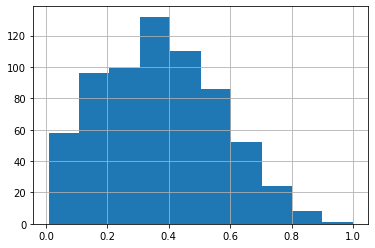

In [428]:
import matplotlib.pyplot as plt
pd.Series(similarities[key_topic]).hist()

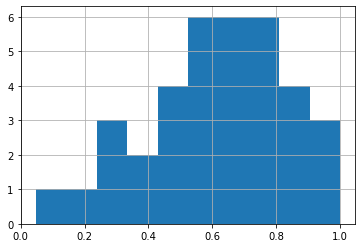

In [429]:
pd.Series(topic_similarities[key_topic]).hist()